In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
import matplotlib.pyplot as plt 
%matplotlib inline 


In [2]:
imagesDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\image"
masksDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\label"
images = sorted(
    [
        os.path.join(imagesDir, fname)
        for fname in os.listdir(imagesDir)
        if fname.endswith(".tif")
    ]
)
masks = sorted(
    [
        os.path.join(masksDir, fname)
        for fname in os.listdir(masksDir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

In [3]:
im_width = 256
im_height = 256
border = 5

X = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)



In [4]:
from skimage.transform import resize
for n, id_ in enumerate(images):
    img_path = images[n]
    img = keras.utils.load_img(img_path, color_mode = "grayscale")
    x_img = keras.utils.img_to_array(img)
    x_img = resize(x_img, (256,256, 1), mode = 'constant', preserve_range = True)
    X[n] = x_img/255.0
   



In [5]:
for n, id in enumerate(masks):
    mask_path = masks[n]
    mask = keras.utils.img_to_array(keras.utils.load_img(mask_path, color_mode = "grayscale"))
    mask = resize(mask, (256,256, 1), mode = 'constant', preserve_range = True)
    y[n] = mask/255.0
    
print(X.size)
print(y.size)

16449536
16449536


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


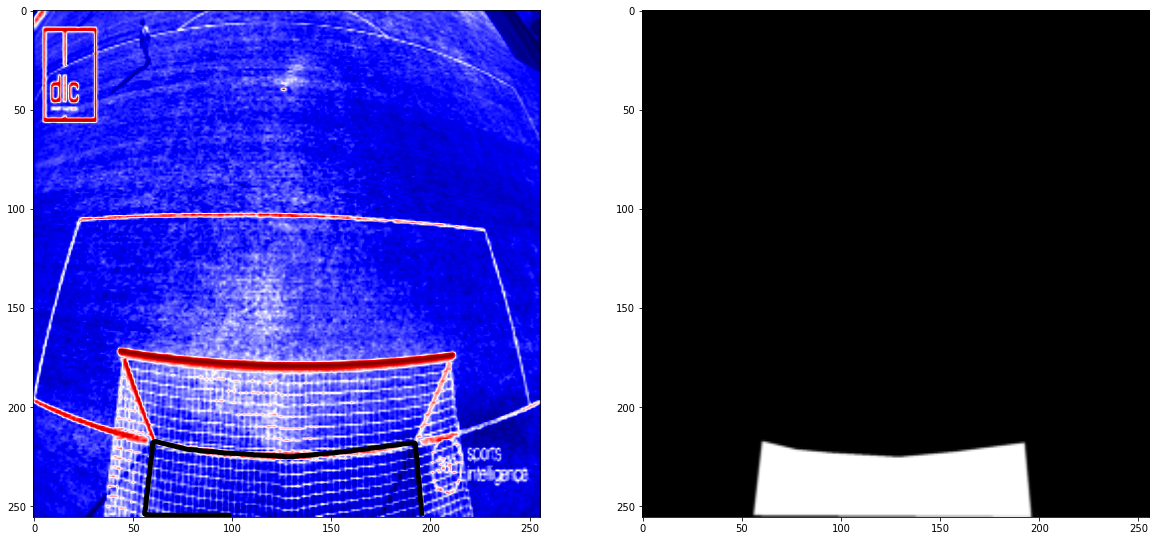

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: 
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')


In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    EarlyStopping(monitor='loss', patience=3)
]

In [11]:
results = model.fit(X_train, y_train, batch_size=32, epochs=300, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/300
8/8 [==============================] - 39s 5s/step - loss: 0.4087 - accuracy: 0.8733 - val_loss: 0.5298 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - 41s 5s/step - loss: 0.2726 - accuracy: 0.9522 - val_loss: 0.5166 - val_accuracy: 0.8968 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - 39s 5s/step - loss: 0.2007 - accuracy: 0.9760 - val_loss: 0.5857 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 4/300
8/8 [==============================] - 39s 5s/step - loss: 0.1649 - accuracy: 0.9788 - val_loss: 0.4989 - val_accuracy: 0.9105 - lr: 0.0010
Epoch 5/300
8/8 [==============================] - 42s 5s/step - loss: 0.1440 - accuracy: 0.9794 - val_loss: 0.4827 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 6/300
8/8 [==============================] - 40s 5s/step - loss: 0.1270 - accuracy: 0.9798 - val_loss: 0.3840 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 7/300
8/8 [==============================] - 39s 5s/step - loss: 0.1135 - accuracy

Epoch 51/300
8/8 [==============================] - 38s 5s/step - loss: 0.0458 - accuracy: 0.9799 - val_loss: 0.0639 - val_accuracy: 0.9790 - lr: 1.0000e-05
Epoch 52/300
8/8 [==============================] - 38s 5s/step - loss: 0.0467 - accuracy: 0.9796 - val_loss: 0.0604 - val_accuracy: 0.9797 - lr: 1.0000e-05


In [18]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


1/1 [==============================] - 1s 807ms/step


In [19]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [20]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].axis('off')
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    
    ax[1].axis('off')
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('goal mask')

    ax[2].axis('off')
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('goal Predicted')
    
    
    ax[3].axis('off')
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('goal Predicted binary');

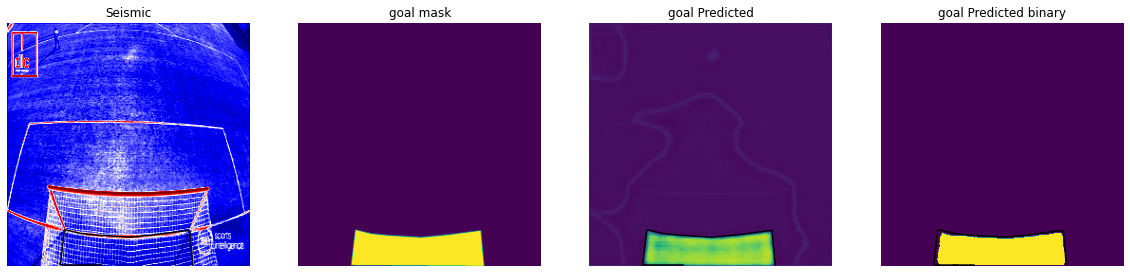

In [21]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


26


C:\Users\viers\AppData\Local\Temp\ipykernel_15844\3448506809.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(20, 10))


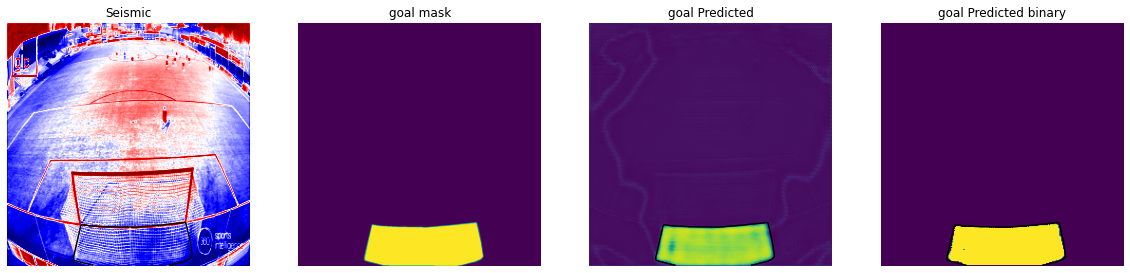

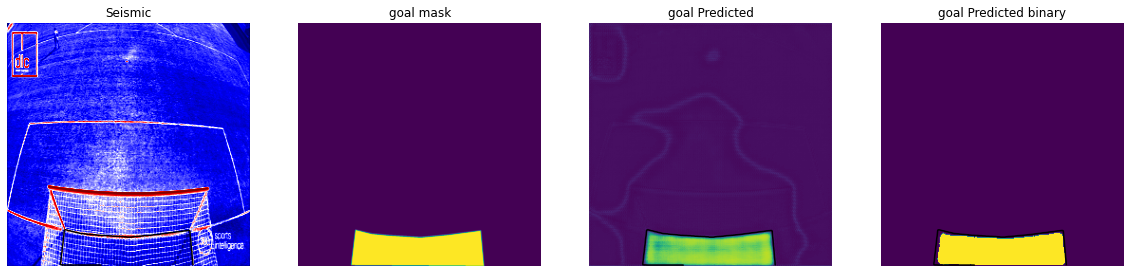

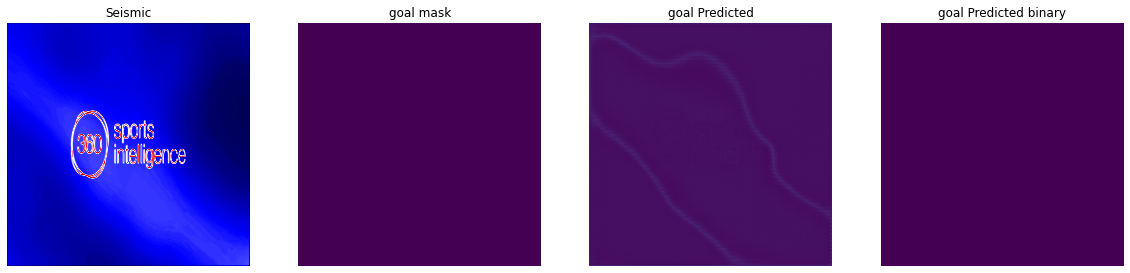

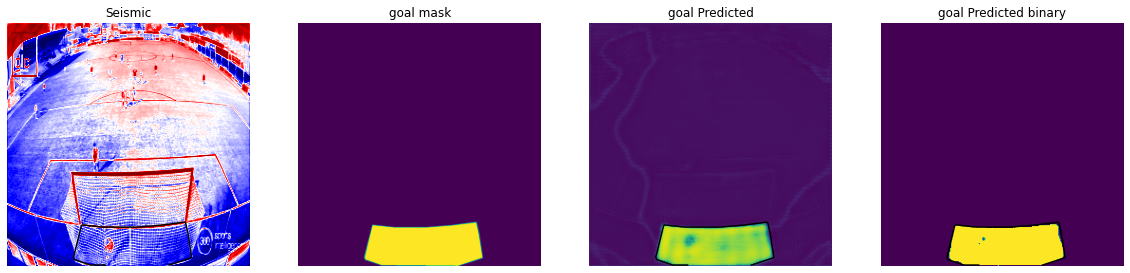

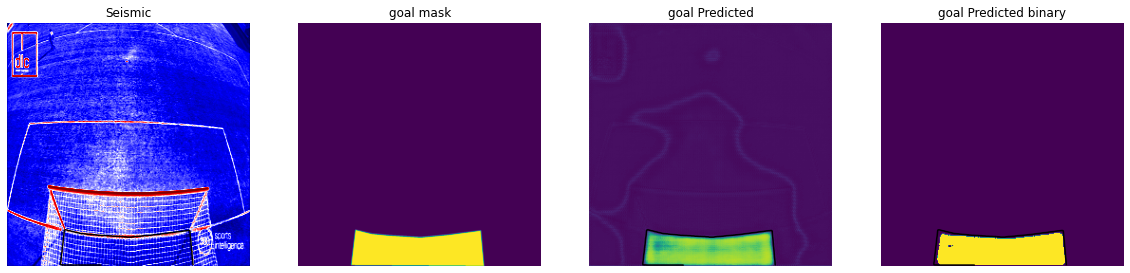

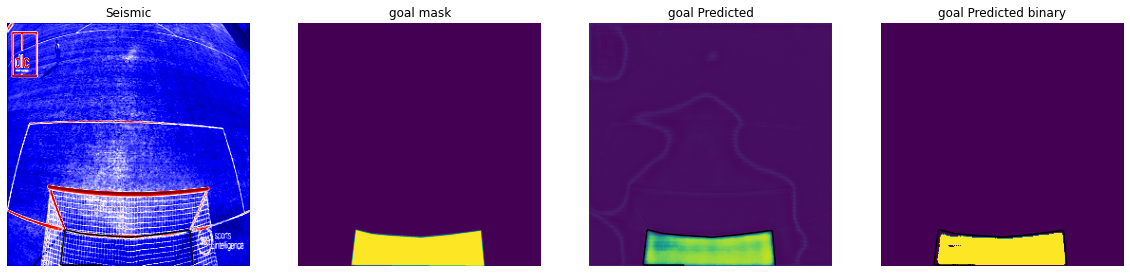

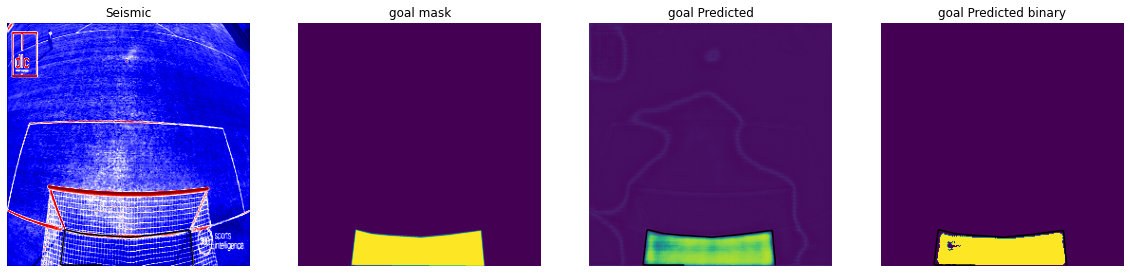

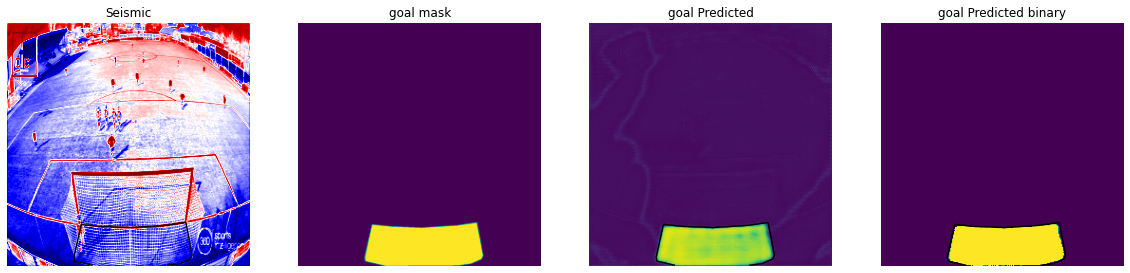

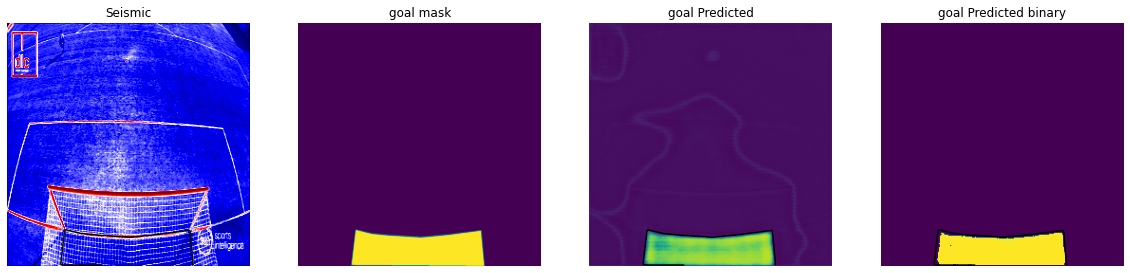

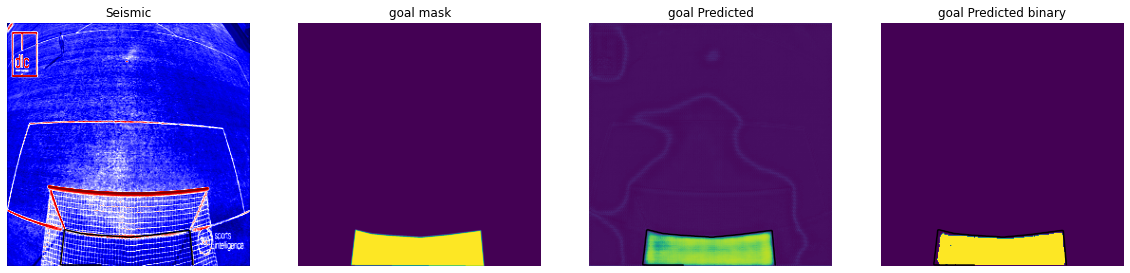

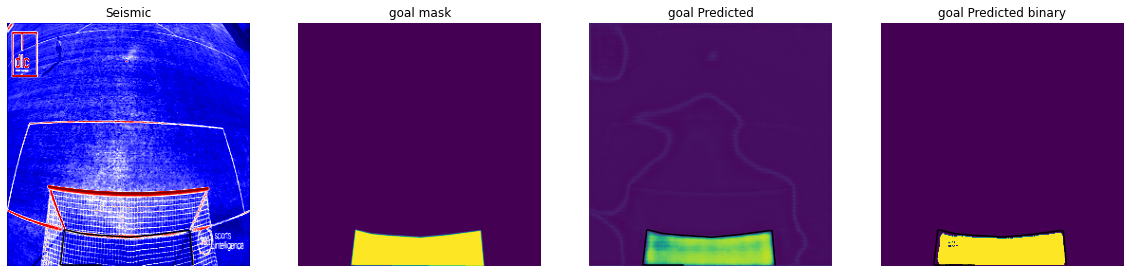

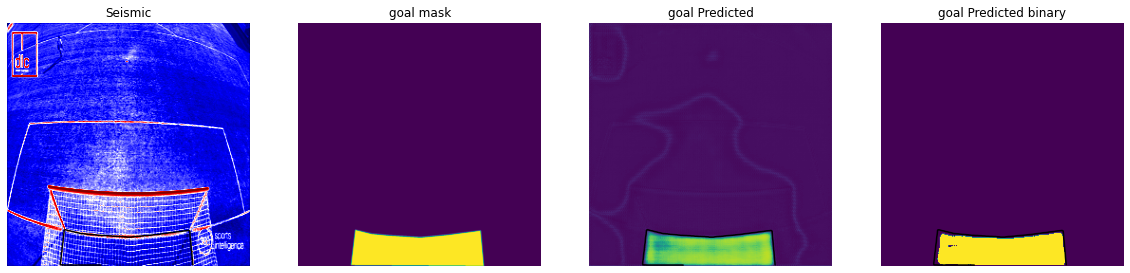

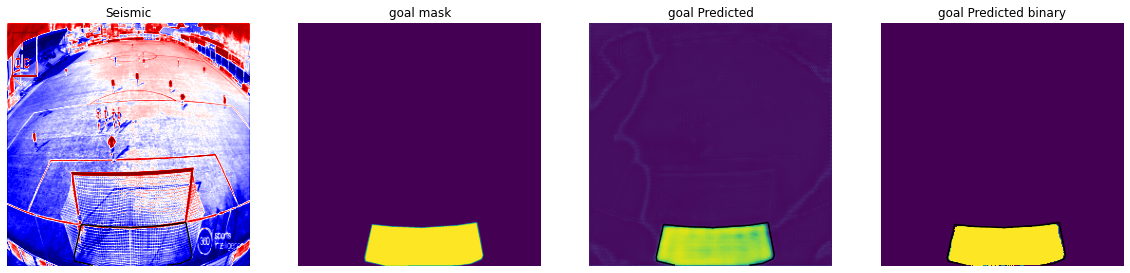

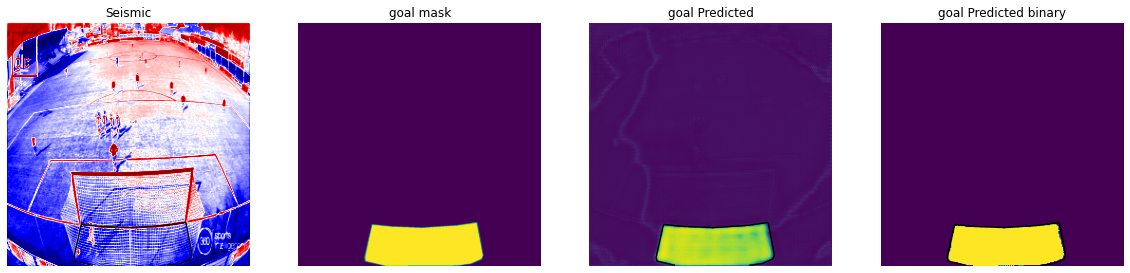

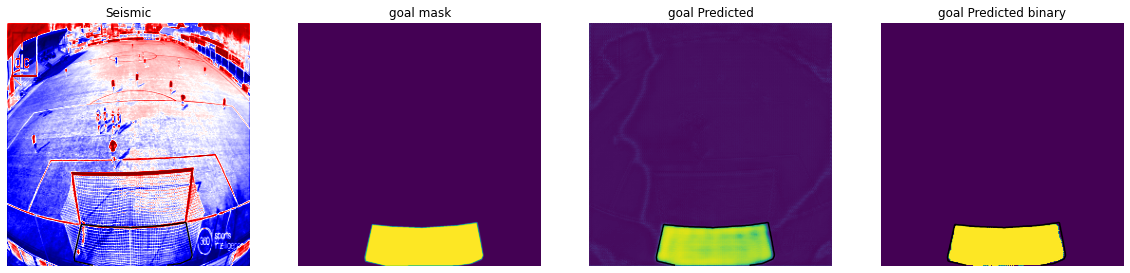

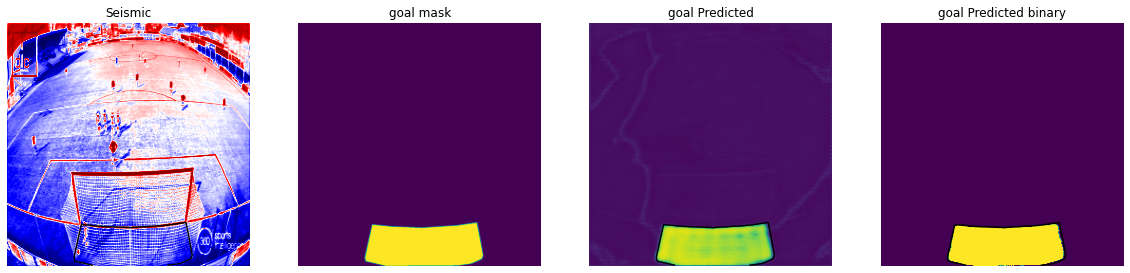

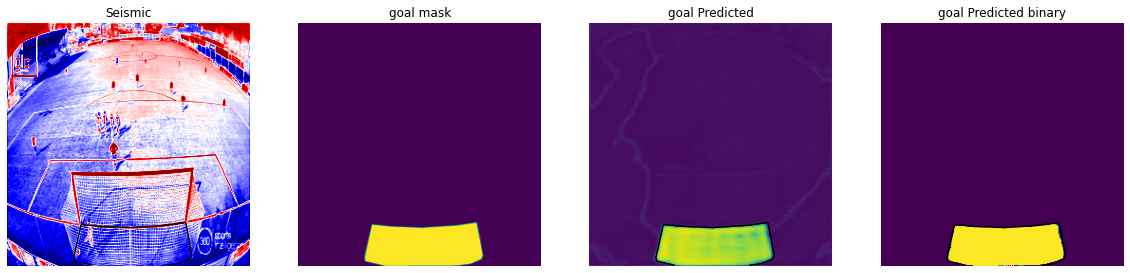

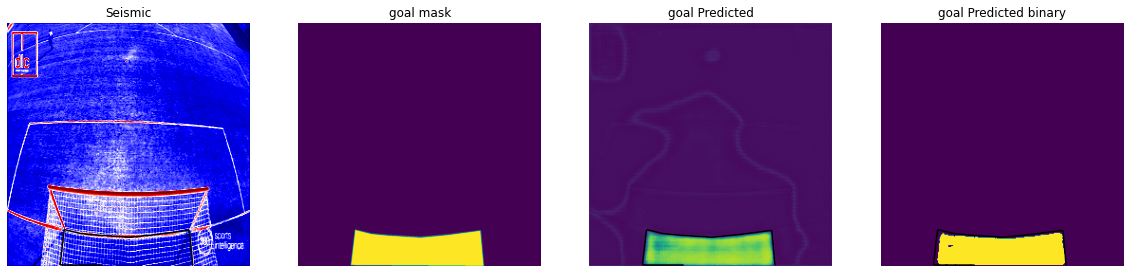

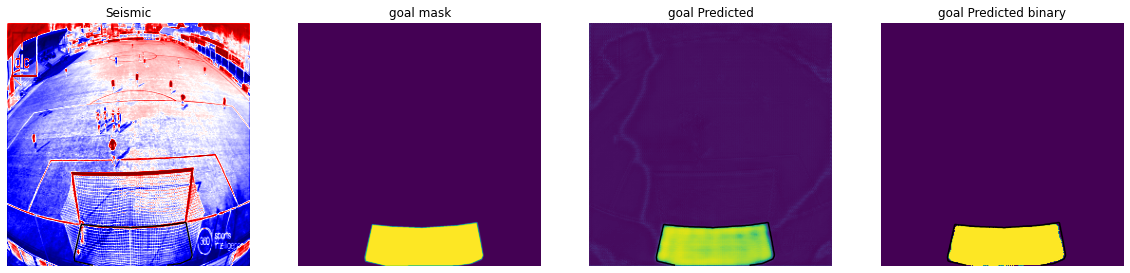

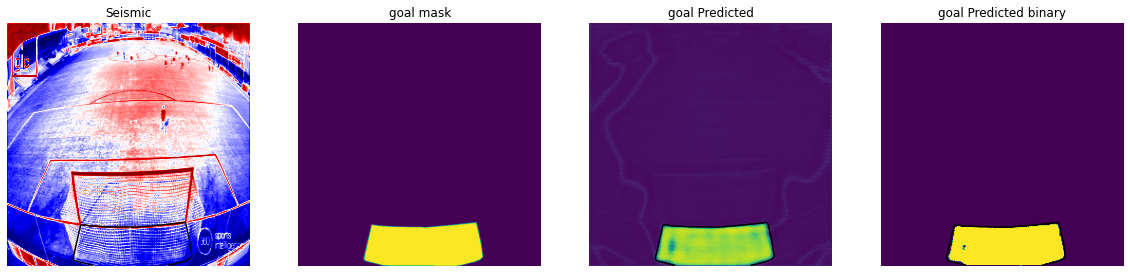

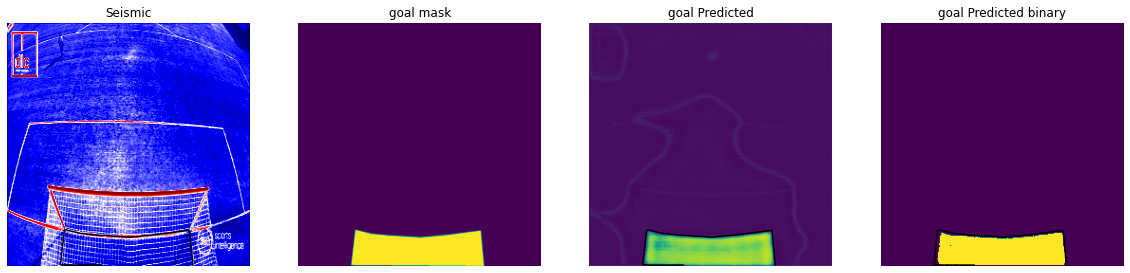

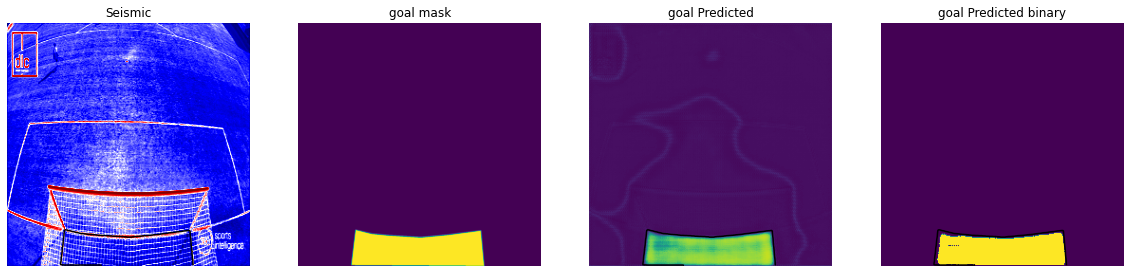

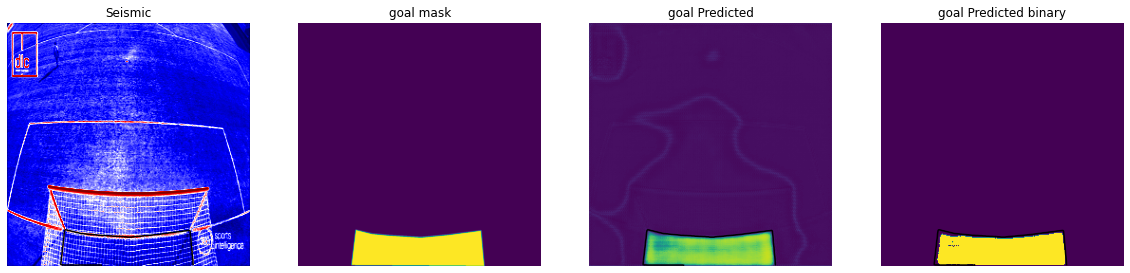

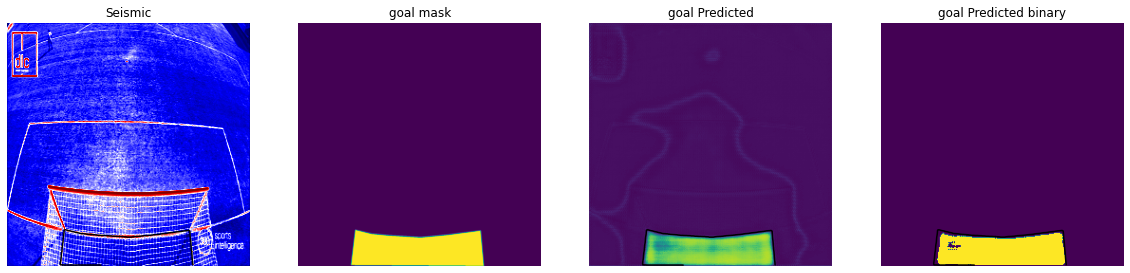

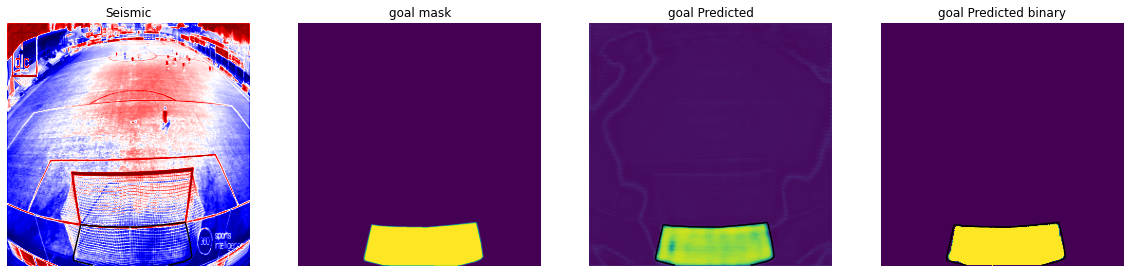

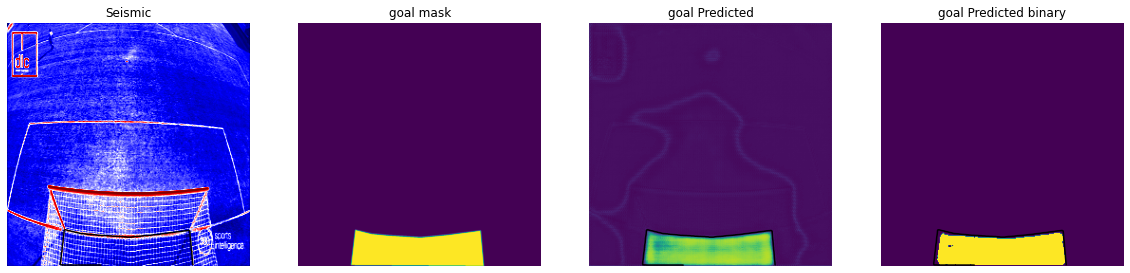

In [22]:
print(len(preds_val_t))
for i in range(0,len(preds_val_t)):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i)

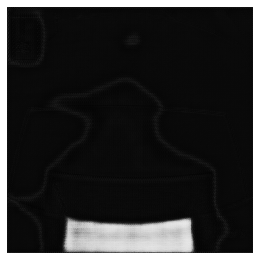

In [23]:
imshow((preds_val[1]))
plt.axis('off')
plt.show()

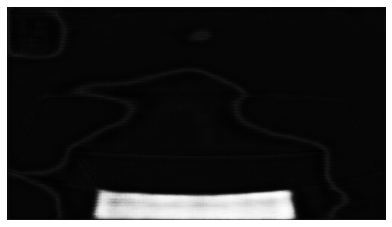

In [24]:
import cv2

img = resize(preds_val[1], (1080,1920), mode = 'constant', preserve_range = True)
img = img - img.min() # Now between 0 and 8674
img = img / img.max() * 255
predictedImg = np.uint8(img)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_BGR2GRAY)

imshow(predictedImg)
plt.axis('off')
plt.show()

In [25]:
ret,predictedImg = cv2.threshold(predictedImg, 100, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(predictedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

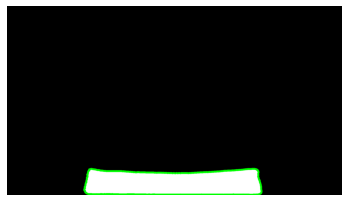

In [26]:
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
cv2.drawContours(predictedImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(predictedImg)


In [27]:
print(contours)

(array([[[481, 930]],

       [[480, 931]],

       [[479, 931]],

       ...,

       [[484, 930]],

       [[483, 930]],

       [[482, 930]]], dtype=int32),)


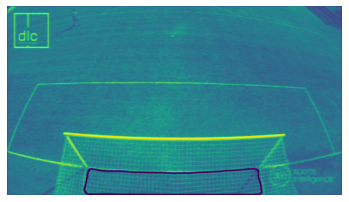

In [28]:
testImg = resize(X_train[7], (1080,1920), mode = 'constant', preserve_range = True)
cv2.drawContours(testImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(testImg)


In [29]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [30]:
from shapely.geometry import Point, Polygon
import sys
import numpy
contours = np.squeeze(contours)
numpy.set_printoptions(threshold=sys.maxsize)
print(contours)

[[ 481  930]
 [ 480  931]
 [ 479  931]
 [ 478  931]
 [ 477  932]
 [ 476  932]
 [ 475  932]
 [ 474  932]
 [ 473  933]
 [ 472  933]
 [ 471  934]
 [ 470  934]
 [ 471  935]
 [ 471  936]
 [ 471  937]
 [ 472  938]
 [ 471  939]
 [ 470  939]
 [ 469  940]
 [ 468  941]
 [ 467  942]
 [ 467  943]
 [ 466  944]
 [ 465  945]
 [ 465  946]
 [ 464  947]
 [ 464  948]
 [ 464  949]
 [ 464  950]
 [ 464  951]
 [ 463  952]
 [ 463  953]
 [ 463  954]
 [ 463  955]
 [ 463  956]
 [ 463  957]
 [ 463  958]
 [ 463  959]
 [ 462  960]
 [ 461  961]
 [ 460  962]
 [ 459  963]
 [ 459  964]
 [ 460  965]
 [ 460  966]
 [ 461  967]
 [ 461  968]
 [ 461  969]
 [ 461  970]
 [ 461  971]
 [ 461  972]
 [ 461  973]
 [ 461  974]
 [ 461  975]
 [ 461  976]
 [ 460  977]
 [ 459  978]
 [ 458  979]
 [ 457  980]
 [ 457  981]
 [ 457  982]
 [ 457  983]
 [ 457  984]
 [ 457  985]
 [ 458  986]
 [ 458  987]
 [ 458  988]
 [ 458  989]
 [ 457  990]
 [ 457  991]
 [ 456  992]
 [ 456  993]
 [ 456  994]
 [ 455  995]
 [ 455  996]
 [ 455  997]
 [ 455  998]

In [31]:
poly = Polygon(contours)

In [32]:
p1 = Point(1137,963)
p2 = Point(1147,354)
p3 = Point(736,1011)
p4 = Point(729,455)
print(p1.within(poly))
print(p2.within(poly))
print(p3.within(poly))
print(p4.within(poly))


True
False
True
False


In [33]:
model.save(r'C:\Users\viers\OneDrive\Bureaublad\MCT\sem4\IndustryProject\IndustryProject\TrainedModels\Unet_Segment_Model_nullTest.h5')